<a href="https://colab.research.google.com/github/shavirazh/text-classification-using-CNN-with-Word2vec-Glove-FastText/blob/main/notebook-copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import gensim
from wordcloud import WordCloud, STOPWORDS
from gensim.models import KeyedVectors
import gensim.models.keyedvectors as word2vec
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Activation, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Reshape, Flatten, Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
from keras.models import model_from_json
import pickle
import json
import logging

logging.basicConfig(format='%(asctime)s : %(levelname) s : %(message)s', level=logging.INFO)

print('ALL LIBRARY IMPORTED.')

ALL LIBRARY IMPORTED.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Data

In [ ]:
df = pd.read_csv('drive/MyDrive/dataset/tweets_data.csv')
print('Data loaded.\n')

Data loaded.



In [ ]:
df.head()

,Unnamed: 0,tweet,label
0,0,father dysfunctional selfish drag kid dysfunct...,0
1,1,thanks lyft credit cant use cause offer wheelc...,0
2,2,bihday majesty,0
3,3,model love take time urð ðððð ððð,0
4,4,factsguide society motivation,0


In [ ]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
df.head()

,tweet,label
0,father dysfunctional selfish drag kid dysfunct...,0
1,thanks lyft credit cant use cause offer wheelc...,0
2,bihday majesty,0
3,model love take time urð ðððð ððð,0
4,factsguide society motivation,0


Data ini telah dilakukan preprocessing. Tahap-tahap yang dilakukan antara lain: casefolding, stopwords removal, dll.
Perlu diperhatikan untuk mengatasi slang words dan emoji removal.

In [ ]:
df.isnull().sum()

tweet    18
label     0
dtype: int64

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56727 entries, 0 to 56744
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   56727 non-null  object
 1   label   56727 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


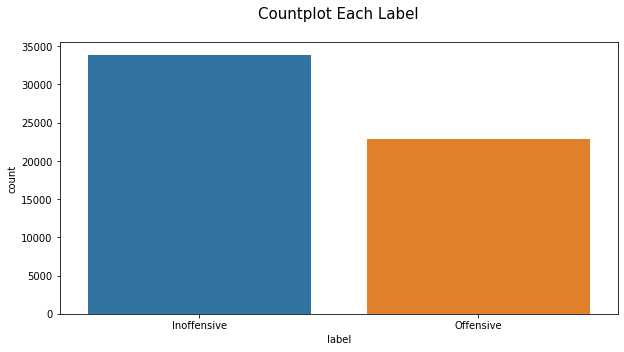

TypeError: ignored

In [ ]:
# Jumlah tweet masing-masing label / count plot label
df_label = df['label'].replace({0: 'Inoffensive',
                               1: 'Offensive'})

plt.figure(figsize=(10,5))
sns.countplot(df_label)
plt.title('Countplot Each Label\n', fontsize=15)
plt.show()

# Word cloud untuk tweet yang TIDAK mengandung ucapan penghinaan/kebencian
inoffensive = df[df['label']==0]
inoffensive_tweets = " ".join(tweet for tweet in inoffensive.tweet)
inoffensive_word_cloud = WordCloud(collocations = False, 
                                   background_color = 'white',
                                  max_words=100,
                                  max_font_size=50,
                                  stopwords=stopwords).generate(inoffensive_tweets)
plt.figure(figsize=(15,7))
plt.imshow(inoffensive_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Word cloud untuk tweet yang mengandung ucapan penghinaan/kebencian
offensive = df[df['label']==1]
offensive_tweets = " ".join(tweet for tweet in offensive.tweet)
offensive_word_cloud = WordCloud(collocations = False, 
                                   background_color = 'white',
                                  stopwords=stopwords,
                                max_font_size=35).generate(offensive_tweets)
plt.figure(figsize=(8,7))
plt.imshow(offensive_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Jumlah missing values
df.isnull().sum()

## Only take 20.000 tweets

In [ ]:
df_1 = df[df['label'] == 1]
df_0 = df[df['label'] == 0]

df_1 = df_1.sample(n=10000)
df_0 = df_0.sample(n=10000)

In [ ]:
df = pd.concat([df_1, df_0], ignore_index = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   20000 non-null  object
 1   label   20000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


In [ ]:
df['label'].value_counts()

1    10000
0    10000
Name: label, dtype: int64

# Preprocessing data

In [ ]:
# Menghapus missing values
df.dropna(inplace=True)

# Casefolding
df['tweet_lower'] = df['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df.drop('tweet', axis=1, inplace=True)

# Stopwords removal
stop = stopwords.words("english")
df['tweet_stopwords'] = df['tweet_lower'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df.drop('tweet_lower', axis=1, inplace=True)

# Punctuation marks removal
df['tweet_punc'] = df['tweet_stopwords'].str.replace('(?:\@|http?\://|https?\://|www)\S+', '')
df['tweet_punc'] = df['tweet_punc'].str.replace('[^\w\s]', '')
df['tweet_punc'] = df['tweet_punc'].str.replace('[0-9]+', '')
df.drop('tweet_stopwords', axis=1, inplace=True)

# Frequent words removal
freq = ['rt','im','ð','amp','u','â','retweet']
df['tweet_comm_remv'] = df['tweet_punc'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
df.drop('tweet_punc', axis=1, inplace=True)

# Rare words removal
rare = pd.Series(' '.join(df['tweet_comm_remv']).split()).value_counts()[-100:]
rare = list(rare.index)
df['tweet_rare_remv'] = df['tweet_comm_remv'].apply(lambda x: " ".join(x for x in x.split() if x not in rare))
df.drop('tweet_comm_remv', axis=1, inplace=True)

df = df.rename(columns = {'twet_comm_remv':'tweet'})

# Build corpus

In [ ]:
# Membuat korpus
corpus = df['tweet'].apply(gensim.utils.simple_preprocess)

# Memberi indeks pada teks
token = Tokenizer()
token.fit_on_texts(corpus)
token.index_word
token.texts_to_sequences(corpus)

#Jumlah kata dalam korpus
vocal = len(token.index_word)+1
print('There are {} words.'.format(vocal))

There are 24246 words.


In [ ]:
corpus = df['tweet'].apply(gensim.utils.simple_preprocess)
corpus

0                  [would, take, avitar, projecting, hate]
1        [word, factory, race, denial, prevents, healin...
2                                  [flexing, nigga, bitch]
3                                             [dad, bitch]
4                  [could, died, called, mom, bitch, lmao]
                               ...                        
19995    [help, run, first, webinar, comms, var, livetw...
19996    [yesmind, counting, find, them, hospital, digi...
19997    [nd, oldest, daughter, childrenâour, beautiful...
19998    [lot, pakistani, twitter, folk, make, like, to...
19999    [best, site, find, interracial, single, interr...
Name: tweet, Length: 20000, dtype: object

In [ ]:
token = Tokenizer()
print('Done.')

Done.


In [ ]:
token.fit_on_texts(corpus)
print('Done.')

Done.


In [ ]:
token.index_word

{1: 'bitch',
 2: 'hoe',
 3: 'like',
 4: 'love',
 5: 'day',
 6: 'pussy',
 7: 'get',
 8: 'nigga',
 9: 'as',
 10: 'got',
 11: 'fuck',
 12: 'shit',
 13: 'happy',
 14: 'time',
 15: 'one',
 16: 'aint',
 17: 'lol',
 18: 'cant',
 19: 'know',
 20: 'go',
 21: 'life',
 22: 'make',
 23: 'girl',
 24: 'want',
 25: 'see',
 26: 'people',
 27: 'good',
 28: 'new',
 29: 'today',
 30: 'need',
 31: 'look',
 32: 'trash',
 33: 'think',
 34: 'say',
 35: 'me',
 36: 'back',
 37: 'take',
 38: 'thats',
 39: 'really',
 40: 'you',
 41: 'fucking',
 42: 'come',
 43: 'man',
 44: 'bad',
 45: 'yall',
 46: 'never',
 47: 'still',
 48: 'friend',
 49: 'yo',
 50: 'work',
 51: 'positive',
 52: 'right',
 53: 'thankful',
 54: 'year',
 55: 'hate',
 56: 'even',
 57: 'father',
 58: 'let',
 59: 'it',
 60: 'way',
 61: 'ððð',
 62: 'bihday',
 63: 'white',
 64: 'would',
 65: 'smile',
 66: 'going',
 67: 'thing',
 68: 'best',
 69: 'bird',
 70: 'little',
 71: 'woman',
 72: 'feel',
 73: 'always',
 74: 'call',
 75: 'faggot',
 76: 'real',
 7

In [ ]:
token.texts_to_sequences(corpus)

In [ ]:
vocal = len(token.index_word)+1
print('There are {} words.'.format(vocal))

There are 24156 words.


# Pad sequences & defining x and y

In [ ]:
maxword = 30
print('Done.')

Done.


In [ ]:
X = token.texts_to_sequences(corpus)
X = pad_sequences(X, maxlen = maxword, padding='post')
print('X defined.')

X defined.


In [ ]:
X.shape

(20000, 30)

In [ ]:
y = df['label'].values.tolist()
print('y defined.')

y defined.


Pengujian splitting training & testing data berdasarkan skenario. 
60:40
75:25
80:20
dll.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state = 42)
print('Training and testing data defined.')

Training and testing data defined.


In [ ]:
# Mendefinisikan X dan Y
X = token.texts_to_sequences(corpus)
X = pad_sequences(X, maxlen = 30, padding='post')
print('x defined')

y = df['label'].values.tolist()
print('y defined.')

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state = 42)
print('Training and testing data defined.')

x defined
y defined.
Training and testing data defined.


# Define embedding layer

## Word2vec

In [ ]:
#w2vModel = gensim.models.keyedvectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True, limit=150000)
#w2vModel.save_word2vec_format('w2vModel.bin', binary=True)

pretrainedpath = 'drive/MyDrive/dataset/w2vModel.bin'
w2vmodel = KeyedVectors.load_word2vec_format(pretrainedpath, binary=True)
print('Model word2vec loaded.')

2022-07-18 11:06:15,817 : INFO : loading projection weights from drive/MyDrive/dataset/w2vModel.bin
2022-07-18 11:06:19,238 : INFO : loaded (150000, 300) matrix from drive/MyDrive/dataset/w2vModel.bin


Model word2vec loaded.


In [ ]:
embedding_layer = Embedding(input_dim=150000, output_dim=300, weights=[w2vmodel.vectors], 
                            input_length=X.shape[1])
print('Embedding layer defined.')

Embedding layer defined.


# Build CNN Model

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv1D(filters=128, kernel_size=7, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.01),
                 kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.01),
                 kernel_initializer='he_normal'))
model.add(MaxPooling1D(pool_size=3))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(32, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 300)           45000000  
                                                                 
 batch_normalization_41 (Bat  (None, 30, 300)          1200      
 chNormalization)                                                
                                                                 
 dropout_43 (Dropout)        (None, 30, 300)           0         
                                                                 
 conv1d_23 (Conv1D)          (None, 30, 128)           268928    
                                                                 
 batch_normalization_42 (Bat  (None, 30, 128)          512       
 chNormalization)                                                
                                                                 
 dropout_44 (Dropout)        (None, 30, 128)         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
from tensorflow.keras.layers import BatchNormalization

In [ ]:
embedding_layer = Embedding(input_dim=150000, output_dim=300, weights=[w2vmodel.vectors], 
                            input_length=X.shape[1])
print('Embedding layer defined.')

print("training CNN ...")
model = Sequential()

'''EMBEDDING LAYER'''
model.add(embedding_layer)

'''CONVOLUTIONAL & POOLING LAYER'''
model.add(BatchNormalization())
#model.add(Dropout(0.3))
model.add(Conv1D(128,7, activation='relu', padding='same'))
#model.add(GlobalMaxPooling1D())
model.add(MaxPooling1D(pool_size=3))
#model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Flatten())

'''DENSE LAYER/FULLY CONNECTED LAYER(?)'''
model.add(Dense(256, activation='relu'))
#model.add(Dense(2, activation='softmax'))
model.add(Dense(1, activation='softmax')) # output

'''OPTIMIZER FUNCTION '''
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Embedding layer defined.
training CNN ...
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 30, 300)           45000000  
                                                                 
 batch_normalization_3 (Batc  (None, 30, 300)          1200      
 hNormalization)                                                 
                                                                 
 conv1d_3 (Conv1D)           (None, 30, 128)           268928    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 10, 128)          0         
 1D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 10, 128)           0         
                                                                 
 flatten_1 (

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Fitting CNN Model

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print('Done.')

Done.


In [ ]:
print('Jumlah training set:', len(X_train))
print('Jumlah testing set:', len(X_test))

Jumlah training set: 14000
Jumlah testing set: 6000


In [ ]:
print("Training True: {0} ({1:2.2f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1])/len(y_train)*100.0)))
print("Training False: {0} ({1:2.2f}%)\n".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0])/len(y_train)*100.0)))

print("Testing True: {0} ({1:2.2f}%)".format(len(y_test[y_test[:] == 1]), (len(y_test[y_test[:] == 1])/len(y_test)*100.0)))
print("Testing False: {0} ({1:2.2f}%)".format(len(y_test[y_test[:] == 0]), (len(y_test[y_test[:] == 0])/len(y_test)*100.0)))

Training True: 6983 (49.88%)
Training False: 7017 (50.12%)

Testing True: 3017 (50.28%)
Testing False: 2983 (49.72%)


In [ ]:
batch_size = 64
model.fit(X_train, y_train, epochs=5, validation_split=0.2, batch_size=batch_size)

Epoch 1/5
 92/175 [==============>...............] - ETA: 44s - loss: 0.2658 - accuracy: 0.8920

KeyboardInterrupt: ignored

In [ ]:
dataset = pd.read_csv(r'https://github.com/dipanjanS/nlp_workshop_dhs18/raw/master/Unit%2011%20-%20Sentiment%20Analysis%20-%20Unsupervised%20Learning/movie_reviews.csv.bz2', compression='bz2')
dataset['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

# Model evaluation

In [ ]:
loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print('Model loss: {}'.format(loss))
print('Model acc: {}'.format(acc))

188/188 [==============================] - 2s 8ms/step - loss: 0.2193 - accuracy: 0.9203
Model loss: 0.21932008862495422
Model acc: 0.9203333258628845


In [ ]:
y_pred = model.predict(X_test)
print('Prediction done.')

Prediction done.


In [ ]:
labels = [0,1]

In [ ]:
labels = [0,1]
prediction_labels=[]
for p in y_pred:
    prediction_labels.append(labels[np.argmax(p)])

In [ ]:
sum(y_test==prediction_labels)/len(prediction_labels)

0.9203333333333333

In [ ]:
y_pred = prediction_labels

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[2879  104]
 [ 374 2643]]


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.97      0.92      2983
           1       0.96      0.88      0.92      3017

    accuracy                           0.92      6000
   macro avg       0.92      0.92      0.92      6000
weighted avg       0.92      0.92      0.92      6000



In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True,fmt=".0f", cmap="PuRd", annot_kws={"fontsize":12})
plt.title("Sentiment Classification\nAccuracy:{:.3f}".format(accuracy_score(y_test, y_pred)), fontsize=14)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.show()
print("Classification Report:\n", classification_report(y_test, y_pred))

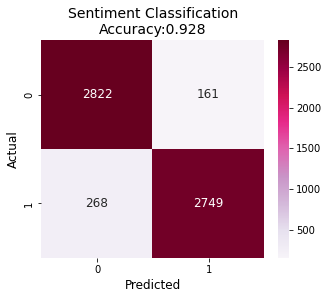

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93      2983
           1       0.94      0.91      0.93      3017

    accuracy                           0.93      6000
   macro avg       0.93      0.93      0.93      6000
weighted avg       0.93      0.93      0.93      6000



In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True,fmt=".0f", cmap="PuRd", annot_kws={"fontsize":12})
plt.title("Sentiment Classification\nAccuracy:{:.3f}".format(accuracy_score(y_test, y_pred)), fontsize=14)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.show()
print("Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
y_pred_train = model.predict(X_train)

In [ ]:
labels_ = [0,1]

prediction_labels_=[]
for p in y_pred_train:
    prediction_labels_.append(labels[np.argmax(p)])
    
y_pred_train = prediction_labels_

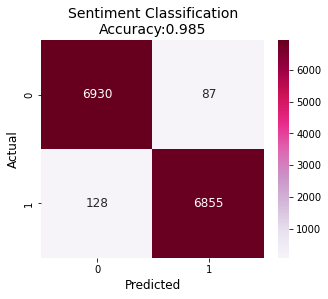

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      7017
           1       0.99      0.98      0.98      6983

    accuracy                           0.98     14000
   macro avg       0.98      0.98      0.98     14000
weighted avg       0.98      0.98      0.98     14000



In [ ]:
cm_ = confusion_matrix(y_train, y_pred_train)
plt.figure(figsize=(5,4))
sns.heatmap(cm_, annot=True,fmt=".0f", cmap="PuRd", annot_kws={"fontsize":12})
plt.title("Sentiment Classification\nAccuracy:{:.3f}".format(accuracy_score(y_train, y_pred_train)), fontsize=14)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.show()
print("Classification Report:\n", classification_report(y_train, y_pred_train))

In [ ]:
def predict_text(txt):
    
    txt = gensim.utils.simple_preprocess(txt)
    txt = token.texts_to_sequences(txt)
    txt = list(filter(None, txt))
    txt = np.reshape(txt, len(txt))
    txt = np.array([txt.tolist()])
    txt = pad_sequences(txt, maxlen = maxword, padding='post')
    
    predict = model.predict(txt)
    predict = np.argmax(predict)
    
    if predict == 0:
        predict_text = ('Your text classification is {}, which means your text DOESN`T contains offensive/harmful word(s).'.format(predict))
    if predict == 1:
        predict_text = ('Your text classification is {}, which means your text contains offensive/harmful word(s).'.format(predict))
    
    return predict_text

In [ ]:
txt = input('Input text')

predict_text(txt)

Input textasian woman freak


'Your text classification is 1, which means your text contains offensive/harmful word(s).'

# Hyperparameter tuning

In [ ]:
# Early Stopping
monitor = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 0)

# Memdefinisikan Model
model_cnn = KerasClassifier(build_fn=model,
                            callbacks=[monitor],
                            verbose=1)

# define the grid search parameters
params_cnn = {'epochs': [30,50],
              'batch_size': [32,64,128]}

ht_cnn = GridSearchCV(model_cnn,
                      param_grid= params_cnn,
                      scoring = 'accuracy')

hyt_cnn = ht_cnn.fit(X_train, y_train, validation_data=(X_test, y_test));
print("\nThe best parameter is {}".format(hyt_cnn.best_params_))
print("\nThe best_accuracy is {}".format(hyt_cnn.best_score_))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  import sys


INFO:tensorflow:Assets written to: ram://a94edd63-823b-44a1-b0e1-5b2704b936c9/assets


2022-06-30 03:39:07,335 : INFO : Assets written to: ram://a94edd63-823b-44a1-b0e1-5b2704b936c9/assets


INFO:tensorflow:Assets written to: ram://b6264d4d-c9fd-41fb-88af-5b8d8258471a/assets


2022-06-30 03:39:11,635 : INFO : Assets written to: ram://b6264d4d-c9fd-41fb-88af-5b8d8258471a/assets


INFO:tensorflow:Assets written to: ram://6106f6e1-9439-48d3-9e8f-a4dfd87c6542/assets


2022-06-30 03:39:16,594 : INFO : Assets written to: ram://6106f6e1-9439-48d3-9e8f-a4dfd87c6542/assets


INFO:tensorflow:Assets written to: ram://32456ad6-1820-4114-acfa-34f16b258ea1/assets


2022-06-30 03:39:21,285 : INFO : Assets written to: ram://32456ad6-1820-4114-acfa-34f16b258ea1/assets


INFO:tensorflow:Assets written to: ram://d2c878a3-90be-40cc-9af4-1c6208d3da31/assets


2022-06-30 03:39:25,401 : INFO : Assets written to: ram://d2c878a3-90be-40cc-9af4-1c6208d3da31/assets


INFO:tensorflow:Assets written to: ram://192db4e5-51df-4e06-ae4c-0e09b5f8b287/assets


2022-06-30 03:39:29,520 : INFO : Assets written to: ram://192db4e5-51df-4e06-ae4c-0e09b5f8b287/assets


INFO:tensorflow:Assets written to: ram://09a4bcd6-358a-4c52-b04e-5b408146e9eb/assets


2022-06-30 03:39:33,606 : INFO : Assets written to: ram://09a4bcd6-358a-4c52-b04e-5b408146e9eb/assets


INFO:tensorflow:Assets written to: ram://a4b10c1c-12e8-412f-8d03-84e16bffffa9/assets


2022-06-30 03:39:38,394 : INFO : Assets written to: ram://a4b10c1c-12e8-412f-8d03-84e16bffffa9/assets


INFO:tensorflow:Assets written to: ram://2cb2c6f6-045e-45e1-a94f-35c89cb83c61/assets


2022-06-30 03:39:42,515 : INFO : Assets written to: ram://2cb2c6f6-045e-45e1-a94f-35c89cb83c61/assets


INFO:tensorflow:Assets written to: ram://daa65e6e-53b4-4594-a64d-9284ad937d4f/assets


2022-06-30 03:39:46,676 : INFO : Assets written to: ram://daa65e6e-53b4-4594-a64d-9284ad937d4f/assets


INFO:tensorflow:Assets written to: ram://824ac6f9-ec15-478d-bab2-09d9fbcd9b80/assets


2022-06-30 03:39:50,832 : INFO : Assets written to: ram://824ac6f9-ec15-478d-bab2-09d9fbcd9b80/assets


INFO:tensorflow:Assets written to: ram://76f7b9cd-2a60-44ce-9e61-0eeccd133c21/assets


2022-06-30 03:39:55,747 : INFO : Assets written to: ram://76f7b9cd-2a60-44ce-9e61-0eeccd133c21/assets


INFO:tensorflow:Assets written to: ram://99c0ef55-bc88-4fad-b157-d13ca368fd27/assets


2022-06-30 03:39:59,941 : INFO : Assets written to: ram://99c0ef55-bc88-4fad-b157-d13ca368fd27/assets


INFO:tensorflow:Assets written to: ram://a22657ca-0c52-423f-95d0-ff57f8d3b2f6/assets


2022-06-30 03:40:04,060 : INFO : Assets written to: ram://a22657ca-0c52-423f-95d0-ff57f8d3b2f6/assets


INFO:tensorflow:Assets written to: ram://a1236306-51bc-4aaa-bb3b-576482fec582/assets


2022-06-30 03:40:08,266 : INFO : Assets written to: ram://a1236306-51bc-4aaa-bb3b-576482fec582/assets


INFO:tensorflow:Assets written to: ram://dedcac48-fb9d-4c59-a9e5-9659cb17ba13/assets


2022-06-30 03:40:12,950 : INFO : Assets written to: ram://dedcac48-fb9d-4c59-a9e5-9659cb17ba13/assets


INFO:tensorflow:Assets written to: ram://1ace6907-e110-43d8-b3c0-cf9417cb09cd/assets


2022-06-30 03:40:17,137 : INFO : Assets written to: ram://1ace6907-e110-43d8-b3c0-cf9417cb09cd/assets


INFO:tensorflow:Assets written to: ram://c5320292-ec91-48f7-ba19-c1932eab580b/assets


2022-06-30 03:40:21,324 : INFO : Assets written to: ram://c5320292-ec91-48f7-ba19-c1932eab580b/assets


INFO:tensorflow:Assets written to: ram://21c556d1-a056-4fec-8c31-d7f0116b9b88/assets


2022-06-30 03:40:25,398 : INFO : Assets written to: ram://21c556d1-a056-4fec-8c31-d7f0116b9b88/assets


INFO:tensorflow:Assets written to: ram://2769e6fb-02a5-448f-ac3f-c956c2cdc090/assets


2022-06-30 03:40:29,496 : INFO : Assets written to: ram://2769e6fb-02a5-448f-ac3f-c956c2cdc090/assets


INFO:tensorflow:Assets written to: ram://8c1968c9-1ec9-404b-a0fa-b094a9f857f9/assets


2022-06-30 03:40:34,219 : INFO : Assets written to: ram://8c1968c9-1ec9-404b-a0fa-b094a9f857f9/assets


INFO:tensorflow:Assets written to: ram://bc6f17b2-8710-48bf-b116-26dd0423f800/assets


2022-06-30 03:40:38,342 : INFO : Assets written to: ram://bc6f17b2-8710-48bf-b116-26dd0423f800/assets


INFO:tensorflow:Assets written to: ram://91d265d4-d06d-4217-93a7-ee816706261c/assets


2022-06-30 03:40:42,477 : INFO : Assets written to: ram://91d265d4-d06d-4217-93a7-ee816706261c/assets


INFO:tensorflow:Assets written to: ram://9e989a53-7677-4c41-aea7-43332fe08425/assets


2022-06-30 03:40:46,572 : INFO : Assets written to: ram://9e989a53-7677-4c41-aea7-43332fe08425/assets


INFO:tensorflow:Assets written to: ram://5f4b0b7f-f990-4dcb-ac0b-c39940c3d9af/assets


2022-06-30 03:40:51,392 : INFO : Assets written to: ram://5f4b0b7f-f990-4dcb-ac0b-c39940c3d9af/assets


INFO:tensorflow:Assets written to: ram://7fea0c44-f4f3-4205-9cd8-71a3a3deb303/assets


2022-06-30 03:40:56,315 : INFO : Assets written to: ram://7fea0c44-f4f3-4205-9cd8-71a3a3deb303/assets


INFO:tensorflow:Assets written to: ram://50d1a731-9949-4652-b040-811a20ab874e/assets


2022-06-30 03:41:01,147 : INFO : Assets written to: ram://50d1a731-9949-4652-b040-811a20ab874e/assets


INFO:tensorflow:Assets written to: ram://0013a231-dcdc-4980-8279-05b1e4726350/assets


2022-06-30 03:41:05,317 : INFO : Assets written to: ram://0013a231-dcdc-4980-8279-05b1e4726350/assets


INFO:tensorflow:Assets written to: ram://c4b50d37-5f1a-4168-8b9e-ca0794bb7a7b/assets


2022-06-30 03:41:10,068 : INFO : Assets written to: ram://c4b50d37-5f1a-4168-8b9e-ca0794bb7a7b/assets


INFO:tensorflow:Assets written to: ram://e9722e51-182f-4d95-9522-87cbffc62dc7/assets


2022-06-30 03:41:14,214 : INFO : Assets written to: ram://e9722e51-182f-4d95-9522-87cbffc62dc7/assets


INFO:tensorflow:Assets written to: ram://4e290038-dabe-454b-a2a7-b1e2cb508323/assets


2022-06-30 03:41:18,427 : INFO : Assets written to: ram://4e290038-dabe-454b-a2a7-b1e2cb508323/assets
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 236, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappe

INFO:tensorflow:Assets written to: ram://1db6062c-1610-4f6f-9891-af6d19b8ca71/assets


2022-06-30 03:41:22,682 : INFO : Assets written to: ram://1db6062c-1610-4f6f-9891-af6d19b8ca71/assets


INFO:tensorflow:Assets written to: ram://f25fa0ca-3ac8-4712-8d4f-726e3e07ad8f/assets


2022-06-30 03:41:27,475 : INFO : Assets written to: ram://f25fa0ca-3ac8-4712-8d4f-726e3e07ad8f/assets


ValueError: ignored

## Epochs & Batch size

In [ ]:
# Using EarlyStopping
callback =  EarlyStopping(monitor='val_loss',  mode='min', patience=8),
checkpoint = ModelCheckpoint(filepath='./',
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        save_best_only=True)
#epochs 30, batch size 64
history_epochs = model.fit(X_train, y_train, 
                           epochs=30, 
                           validation_split=0.2, 
                           batch_size=64,
                           callbacks=[callback, checkpoint],
                           validation_data=(X_test, y_test))

Epoch 1/30
175/175 [==============================] - 110s 609ms/step - loss: 3.9455 - accuracy: 0.8897 - val_loss: 2.6100 - val_accuracy: 0.7532
Epoch 2/30
175/175 [==============================] - 106s 603ms/step - loss: 1.1652 - accuracy: 0.9911 - val_loss: 1.0103 - val_accuracy: 0.8496
Epoch 3/30
175/175 [==============================] - 110s 628ms/step - loss: 0.3345 - accuracy: 0.9912 - val_loss: 0.6434 - val_accuracy: 0.9029
Epoch 4/30
175/175 [==============================] - 104s 595ms/step - loss: 0.2037 - accuracy: 0.9915 - val_loss: 0.5992 - val_accuracy: 0.9150
Epoch 5/30
175/175 [==============================] - 105s 599ms/step - loss: 0.1896 - accuracy: 0.9918 - val_loss: 0.5354 - val_accuracy: 0.9229
Epoch 6/30
175/175 [==============================] - 102s 585ms/step - loss: 0.1932 - accuracy: 0.9927 - val_loss: 0.5696 - val_accuracy: 0.9221
Epoch 7/30
175/175 [==============================] - 102s 585ms/step - loss: 0.2257 - accuracy: 0.9909 - val_loss: 0.6208 -

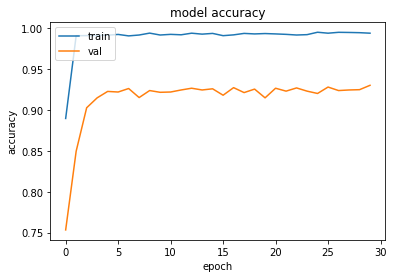

In [ ]:
plt.plot(history_epochs.history['accuracy'])
plt.plot(history_epochs.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

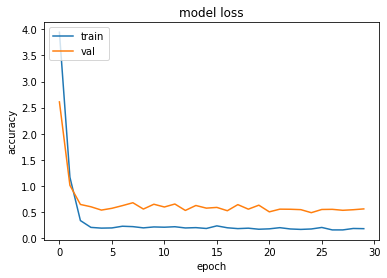

In [ ]:
plt.plot(history_epochs.history['loss'])
plt.plot(history_epochs.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model.evaluate(X_test, y_test, batch_size=64)
print('Model loss: {}'.format(loss))
print('Model acc: {}'.format(acc))

94/94 [==============================] - 3s 34ms/step - loss: 0.5731 - accuracy: 0.9252
Model loss: 0.573114275932312
Model acc: 0.925166666507721


In [ ]:
# Batch size 32
# Using EarlyStopping
callback =  EarlyStopping(monitor='val_loss',  mode='min', patience=8),
checkpoint = ModelCheckpoint(filepath='./',
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        save_best_only=True)

history_b32 = model.fit(X_train, y_train, 
                           epochs=30, 
                           validation_split=0.2, 
                           batch_size=32,
                           callbacks=[callback, checkpoint],
                           validation_data=(X_test, y_test))

Epoch 1/30
350/350 [==============================] - 192s 547ms/step - loss: 3.1452 - accuracy: 0.9389 - val_loss: 1.5763 - val_accuracy: 0.8571
Epoch 2/30
350/350 [==============================] - 194s 553ms/step - loss: 0.5517 - accuracy: 0.9919 - val_loss: 0.6394 - val_accuracy: 0.9232
Epoch 3/30
350/350 [==============================] - 186s 532ms/step - loss: 0.2713 - accuracy: 0.9905 - val_loss: 0.6661 - val_accuracy: 0.9250
Epoch 4/30
350/350 [==============================] - 182s 520ms/step - loss: 0.2523 - accuracy: 0.9923 - val_loss: 0.6513 - val_accuracy: 0.9250
Epoch 5/30
350/350 [==============================] - 186s 531ms/step - loss: 0.2553 - accuracy: 0.9906 - val_loss: 0.6665 - val_accuracy: 0.9250
Epoch 6/30
350/350 [==============================] - 184s 524ms/step - loss: 0.2729 - accuracy: 0.9895 - val_loss: 0.7075 - val_accuracy: 0.9286
Epoch 7/30
350/350 [==============================] - 182s 520ms/step - loss: 0.2833 - accuracy: 0.9891 - val_loss: 0.6656 -

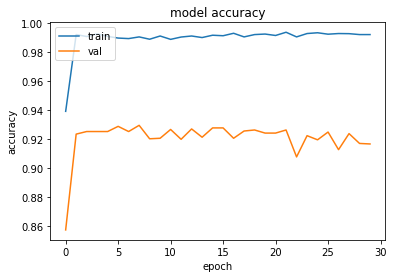

In [ ]:
plt.plot(history_b32.history['accuracy'])
plt.plot(history_b32.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

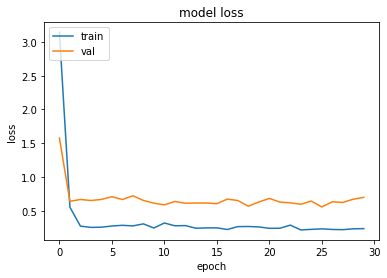

In [ ]:
plt.plot(history_b32.history['loss'])
plt.plot(history_b32.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model.evaluate(X_test, y_test, batch_size=32)
print('Model loss: {}'.format(loss))
print('Model acc: {}'.format(acc))

188/188 [==============================] - 5s 29ms/step - loss: 0.7004 - accuracy: 0.9097
Model loss: 0.7004321217536926
Model acc: 0.9096666574478149


In [ ]:
# Batch size 128
# Using EarlyStopping
#callback =  EarlyStopping(monitor='val_loss',  mode='min', patience=8),
#checkpoint = ModelCheckpoint(filepath='./',
#                                        save_weights_only=True,
#                                        monitor='val_loss',
#                                        mode='min',
#                                        save_best_only=True)

history_b128 = model.fit(X_train, y_train, 
                           epochs=30, 
                           validation_split=0.2, 
                           batch_size=128,
 #                          callbacks=[callback, checkpoint],
                           validation_data=(X_test, y_test))

Epoch 1/30
88/88 [==============================] - 66s 726ms/step - loss: 4.1760 - accuracy: 0.8788 - val_loss: 3.4513 - val_accuracy: 0.5889
Epoch 2/30
88/88 [==============================] - 62s 710ms/step - loss: 1.5348 - accuracy: 0.9966 - val_loss: 2.7739 - val_accuracy: 0.5111
Epoch 3/30
88/88 [==============================] - 63s 718ms/step - loss: 0.4423 - accuracy: 0.9980 - val_loss: 2.1165 - val_accuracy: 0.5154
Epoch 4/30
88/88 [==============================] - 67s 759ms/step - loss: 0.1306 - accuracy: 0.9984 - val_loss: 0.8769 - val_accuracy: 0.7218
Epoch 5/30
88/88 [==============================] - 64s 727ms/step - loss: 0.0767 - accuracy: 0.9980 - val_loss: 0.4834 - val_accuracy: 0.9168
Epoch 6/30
88/88 [==============================] - 63s 712ms/step - loss: 0.0690 - accuracy: 0.9978 - val_loss: 0.4697 - val_accuracy: 0.9250
Epoch 7/30
88/88 [==============================] - 64s 723ms/step - loss: 0.0585 - accuracy: 0.9983 - val_loss: 0.4776 - val_accuracy: 0.9193

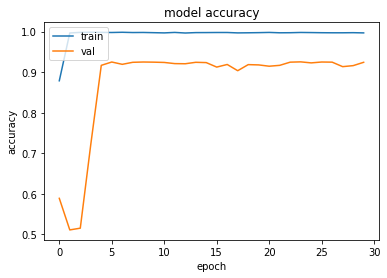

In [ ]:
plt.plot(history_b128.history['accuracy'])
plt.plot(history_b128.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

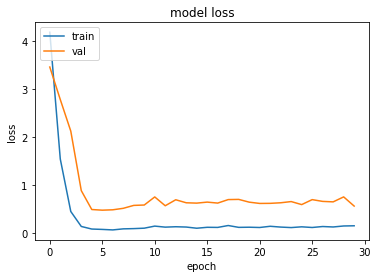

In [ ]:
plt.plot(history_b128.history['loss'])
plt.plot(history_b128.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model.evaluate(X_test, y_test, batch_size=128)
print('Model loss: {}'.format(loss))
print('Model acc: {}'.format(acc))

47/47 [==============================] - 2s 52ms/step - loss: 0.5727 - accuracy: 0.9200
Model loss: 0.572729229927063
Model acc: 0.9200000166893005


Model word2vec memiliki akurasi tertinggi sekitar 0.93 atau 93%. Dengan batch size = 64 dan jumlah epochs 15-20.

# Glove model

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-07-18 17:08:14--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-07-18 17:08:15--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-07-18 17:08:15--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!unzip -q glove.6B.zip

In [ ]:
import os

In [ ]:
%ls

checkpoint  glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip
drive/      glove.6B.200d.txt  glove.6B.50d.txt   sample_data/


In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove.6B.300d.txt'
word2vec_output_file = 'word2vec.txt'
# The first step is to convert the GloVe file format to the word2vec file format. 
# The only difference is the addition of a small header line. This can be done by calling the 
# glove2word2vec() function.
glove2word2vec(glove_input_file, word2vec_output_file)

2022-07-18 17:12:11,596 : INFO : converting 400000 vectors from glove.6B.300d.txt to word2vec.txt


(400000, 300)

In [ ]:
from gensim.models import KeyedVectors
glove = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False, limit=150000)

2022-07-18 17:12:23,247 : INFO : loading projection weights from word2vec.txt
2022-07-18 17:12:47,222 : INFO : loaded (150000, 300) matrix from word2vec.txt


In [ ]:
# calculate: (king - man) + woman = ?
result = glove.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)

2022-06-08 12:17:56,312 : INFO : precomputing L2-norms of word weight vectors


[('queen', 0.6713277101516724)]


## CNN MODEL FOR GLOVE

In [ ]:
embedding_layer = Embedding(input_dim=150000, output_dim=300, weights=[glove.vectors], 
                            input_length=X.shape[1])
print('Embedding layer defined.')
model = Sequential()
model.add(embedding_layer)
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv1D(filters=128, kernel_size=7, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.01),
                 kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.01),
                 kernel_initializer='he_normal'))
model.add(MaxPooling1D(pool_size=3))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(32, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

NameError: ignored

In [ ]:
# Using EarlyStopping
callback =  EarlyStopping(monitor='val_loss',  mode='min', patience=8),
checkpoint = ModelCheckpoint(filepath='./',
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        save_best_only=True)
#epochs 30, batch size 64
history_epochs = model.fit(X_train, y_train, 
                           epochs=30, 
                           validation_split=0.2, 
                           batch_size=64,
                           callbacks=[callback, checkpoint],
                           validation_data=(X_test, y_test))

Epoch 1/30
175/175 [==============================] - 112s 625ms/step - loss: 4.9131 - accuracy: 0.5624 - val_loss: 4.4551 - val_accuracy: 0.4939
Epoch 2/30
175/175 [==============================] - 114s 650ms/step - loss: 2.7921 - accuracy: 0.7378 - val_loss: 3.6590 - val_accuracy: 0.4957
Epoch 3/30
175/175 [==============================] - 112s 639ms/step - loss: 1.4660 - accuracy: 0.8550 - val_loss: 1.4888 - val_accuracy: 0.6675
Epoch 4/30
175/175 [==============================] - 114s 653ms/step - loss: 0.8219 - accuracy: 0.8959 - val_loss: 0.8896 - val_accuracy: 0.7957
Epoch 5/30
175/175 [==============================] - 109s 624ms/step - loss: 0.5450 - accuracy: 0.9243 - val_loss: 0.5299 - val_accuracy: 0.9064
Epoch 6/30
175/175 [==============================] - 110s 631ms/step - loss: 0.4239 - accuracy: 0.9388 - val_loss: 0.4636 - val_accuracy: 0.9164
Epoch 7/30
175/175 [==============================] - 109s 621ms/step - loss: 0.3725 - accuracy: 0.9474 - val_loss: 0.4470 -

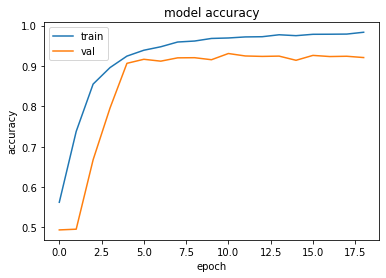

In [ ]:
plt.plot(history_epochs.history['accuracy'])
plt.plot(history_epochs.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

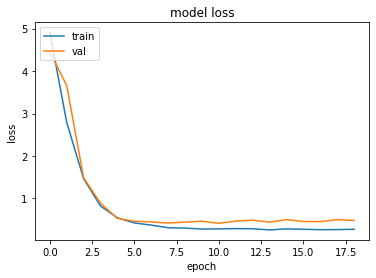

In [ ]:
plt.plot(history_epochs.history['loss'])
plt.plot(history_epochs.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model.evaluate(X_test, y_test, batch_size=64)
print('Model loss: {}'.format(loss))
print('Model acc: {}'.format(acc))

94/94 [==============================] - 4s 38ms/step - loss: 0.4908 - accuracy: 0.9207
Model loss: 0.49075058102607727
Model acc: 0.9206666946411133


In [ ]:
y_pred = model.predict(X_test)
print('Prediction done.')

Prediction done.


In [ ]:
labels = [0,1]
prediction_labels=[]
for p in y_pred:
    prediction_labels.append(labels[np.argmax(p)])

In [ ]:
y_pred = prediction_labels
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[2783  200]
 [ 597 2420]]


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      2983
           1       0.92      0.80      0.86      3017

    accuracy                           0.87      6000
   macro avg       0.87      0.87      0.87      6000
weighted avg       0.87      0.87      0.87      6000



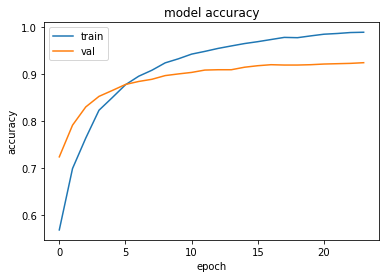

In [ ]:
plt.plot(history_epochs.history['accuracy'])
plt.plot(history_epochs.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

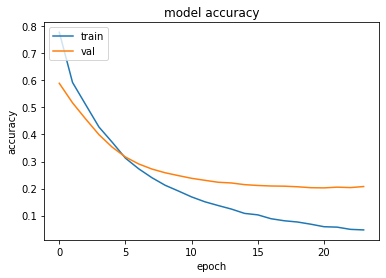

In [ ]:
plt.plot(history_epochs.history['loss'])
plt.plot(history_epochs.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Untuk glove batch size = 64 dan epochs 20-24 menghasilkan akurasi tertinggi 0.92 atau 92%. (dengan performa yang sama seperti word2vec)

# FastText

In [ ]:
!wget https://github.com/facebookresearch/fastText/archive/0.2.0.zip
!unzip 0.2.0.zip
%cd fastText-0.2.0
!make

--2022-07-19 03:08:06--  https://github.com/facebookresearch/fastText/archive/0.2.0.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/facebookresearch/fastText/zip/refs/tags/0.2.0 [following]
--2022-07-19 03:08:06--  https://codeload.github.com/facebookresearch/fastText/zip/refs/tags/0.2.0
Resolving codeload.github.com (codeload.github.com)... 140.82.113.10
Connecting to codeload.github.com (codeload.github.com)|140.82.113.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘0.2.0.zip’

0.2.0.zip               [  <=>               ]   4.10M  16.1MB/s    in 0.3s    

2022-07-19 03:08:06 (16.1 MB/s) - ‘0.2.0.zip’ saved [4304799]

Archive:  0.2.0.zip
7842495a4d64c7a3bb4339d45d6e64321d002ed8
   creating: fastText-0.2.0/
   creating: fastText-0.2.0/.circleci/
  infla

In [ ]:
from gensim.models.wrappers import FastText

#from gensim.models.wrappers import FastText
#!pip install fasttext

In [ ]:
import gensim.downloader as api

# download the pretrained embeddings
#glove_vectors = api.load("glove-wiki-gigaword-100")
#cn_vectors = api.load("conceptnet-numberbatch-17-06-300")
pre_ft_vectors = api.load('fasttext-wiki-news-subwords-300')

2022-07-19 03:08:45,373 : INFO : Creating /root/gensim-data


[==================================================] 100.0% 958.5/958.4MB downloaded


2022-07-19 03:12:45,916 : INFO : fasttext-wiki-news-subwords-300 downloaded
2022-07-19 03:12:45,919 : INFO : loading projection weights from /root/gensim-data/fasttext-wiki-news-subwords-300/fasttext-wiki-news-subwords-300.gz
2022-07-19 03:18:34,830 : INFO : loaded (999999, 300) matrix from /root/gensim-data/fasttext-wiki-news-subwords-300/fasttext-wiki-news-subwords-300.gz


In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec

In [ ]:
pre_ft_vectors.most_similar("queen")

2022-07-19 03:19:26,099 : INFO : precomputing L2-norms of word weight vectors


[('queens', 0.844092607498169),
 ('king', 0.7704246044158936),
 ('queendom', 0.7570821642875671),
 ('queen-', 0.7529805898666382),
 ('queening', 0.7524275779724121),
 ('queen-mother', 0.7511252164840698),
 ('queeny', 0.737737774848938),
 ('princess', 0.7364445924758911),
 ('queenless', 0.7327888011932373),
 ('queen-consort', 0.724591851234436)]

In [ ]:
pretrainedpath = 'MyDrive/dataset/fasttext_model.bin'
fasttext_model = KeyedVectors.load_word2vec_format('drive/MyDrive/dataset/fasttext_model.bin', binary=True)
print('Model fasttext loaded.')

#embedding_layer = Embedding(input_dim=150000, output_dim=300, weights=[w2vmodel.vectors], 
#                            input_length=X.shape[1])
#print('Embedding layer defined.')

2022-07-19 03:26:51,698 : INFO : loading projection weights from drive/MyDrive/dataset/fasttext_model.bin
2022-07-19 03:26:55,627 : INFO : loaded (150000, 300) matrix from drive/MyDrive/dataset/fasttext_model.bin


Model fasttext loaded.


In [ ]:
fasttext_model.most_similar("queen")

2022-06-09 12:48:31,363 : INFO : precomputing L2-norms of word weight vectors


[('queens', 0.8439834117889404),
 ('king', 0.770530641078949),
 ('princess', 0.7364131808280945),
 ('Queen', 0.7063880562782288),
 ('monarch', 0.6960830688476562),
 ('regnant', 0.6684163808822632),
 ('prince', 0.6631122827529907),
 ('royal', 0.6427222490310669),
 ('kings', 0.6354987621307373),
 ('lady', 0.6342077255249023)]

In [ ]:
embedding_layer = Embedding(input_dim=150000, output_dim=300, weights=[fasttext_model.vectors], 
                            input_length=X.shape[1])
print('Embedding layer defined.')

Embedding layer defined.


In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv1D(filters=128, kernel_size=7, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.01),
                 kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.01),
                 kernel_initializer='he_normal'))
model.add(MaxPooling1D(pool_size=3))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(32, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 300)           45000000  
                                                                 
 batch_normalization_6 (Batc  (None, 30, 300)          1200      
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 30, 300)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 30, 128)           268928    
                                                                 
 batch_normalization_7 (Batc  (None, 30, 128)          512       
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 30, 128)          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
batch_size = 64
model.fit(X_train, y_train, epochs=5, validation_split=0.2, batch_size=batch_size)

Epoch 1/5
175/175 [==============================] - 90s 499ms/step - loss: 0.6616 - accuracy: 0.6148 - val_loss: 0.6091 - val_accuracy: 0.8139
Epoch 2/5
175/175 [==============================] - 86s 490ms/step - loss: 0.5231 - accuracy: 0.8209 - val_loss: 0.4117 - val_accuracy: 0.8843
Epoch 3/5
175/175 [==============================] - 85s 485ms/step - loss: 0.3261 - accuracy: 0.8985 - val_loss: 0.2612 - val_accuracy: 0.9139
Epoch 4/5
175/175 [==============================] - 84s 480ms/step - loss: 0.2197 - accuracy: 0.9275 - val_loss: 0.2057 - val_accuracy: 0.9307
Epoch 5/5
175/175 [==============================] - 84s 480ms/step - loss: 0.1663 - accuracy: 0.9463 - val_loss: 0.1822 - val_accuracy: 0.9400


In [ ]:
# Using EarlyStopping
#callback =  EarlyStopping(monitor='val_loss',  mode='min', patience=8),
#checkpoint = ModelCheckpoint(filepath='./',
#                                        save_weights_only=True,
#                                        monitor='val_loss',
#                                        mode='min',
#                                        save_best_only=True)

history_epochs = model.fit(X_train, y_train, 
                           epochs=30, 
                           validation_split=0.2, 
                           batch_size=64,
#                           callbacks=[callback, checkpoint],
                           validation_data=(X_test, y_test))

Epoch 1/30
175/175 [==============================] - 124s 696ms/step - loss: 3.8340 - accuracy: 0.9001 - val_loss: 3.9648 - val_accuracy: 0.5061
Epoch 2/30
106/175 [=================>............] - ETA: 46s - loss: 1.3534 - accuracy: 0.9895

KeyboardInterrupt: ignored

Hypertuning:

Epochs 20, Batch size 32

Epochs 20, Batch size 64

Epochs 20, Batch size 128

Epochs 30, Batch size 32

Epochs 30, Batch size 64

Epochs 30, Batch size 128

Epochs 50, Batch size 32

Epochs 50, Batch size 64

Epochs 50, Batch size 128

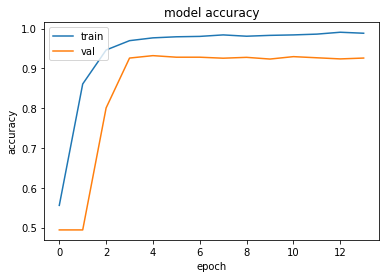

In [ ]:
plt.plot(history_epochs.history['accuracy'])
plt.plot(history_epochs.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

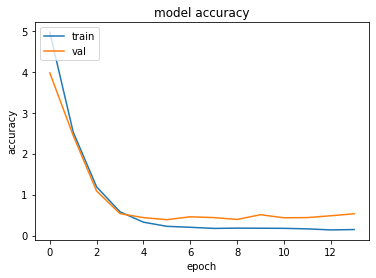

In [ ]:
plt.plot(history_epochs.history['loss'])
plt.plot(history_epochs.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()